# 작업순서

## A. DB 접속 -> 원하는 농장명 입력
- A-1. DB 접속, 농장명 입력
- A-2. 필요한 데이터 테이블의 함수화(나중에)
## B. TBL_DAILY_MILKING_HISTORY, FROM TBL_DAILY_FEED_DASH, TBL_COW_DATA_V2, TBL_SCALE_HISTORY WHERE FARM_CODE의 COW_CODE를 정리함
- B-1. COW_CODE를 불러와서, 중복을 제거하고, txt파일로 저장
- B_2(수동작업). txt파일을 축평원 이력제의 멀티조회를 하여 다운 로딩한 파일을 이 작업파일의 같은 경로에 xlsx로 저장
- B-3. xlsx파일의 이력번호를 빈칸을 제거
## C. 축평원 사육개체 현황에 대해 이력번호로 정리함
- C-1. 축평원 사육개체 현황 API로 받아와서 txt파일로 저장
- C_2(수동작업). txt파일을 축평원 이력제의 멀티조회를 하여 다운 로딩한 파일을 이 작업파일의 같은 경로에 xlsx로 저장
- C-3. xlsx파일의 이력번호를 빈칸을 제거하고 str로 12자리로 만듬
## D. 축평원 사육개체 현황과 DB 현황비교 
- D-1. 두 파일의 이력번호와 겹침 개체, 단일 개체 파악
- D-2. 개체번호 파일 작성
## E. 보정을 위한 기초 데이터 생성 
- E-1. 착유일, 산차의 오류를 제거하기 위해 착유시작일-종류일 테이블 생성
## F. 개체에 대한 관련 데이터 생성 
- F-1. 개체번호에 소의 종류, 월령, 산차, 성별, 착유일, 성우보정으로 정리
- F-2. 착유일, 산차 보정   
- F-3. 착유데이터의 월별 총착유량 합계 테이블을 join
## G. 비용추정 모델 구동
## H. 비용예측 모델 구동

In [2]:
!pip install pymysql
import pymysql
import pandas as pd

## 데이터 베이스 연결_테이블 보기

In [4]:
# 데이터베이스 연결 파라미터
host = "211.191.187.151"  # 데이터베이스 IP 주소
database = "slms"         # 데이터베이스 이름
user = "inpro"            # 사용자 이름
password = "inpro0123"    # 비밀번호

def connect_to_database():
    try:
        connection = pymysql.connect(
            host=host,
            user=user,
            password=password,
            database=database,
            port=3306,
            connect_timeout=10
        )
        print("데이터베이스 연결 성공")
        return connection
    except pymysql.MySQLError as e:
        print(f"데이터베이스 연결 오류: {e}")
        return None

connection = connect_to_database()

데이터베이스 연결 성공


## 목장명 입력

In [6]:
farm_name = input("목장명을 입력하세요: ")

목장명을 입력하세요:  평자연


# B. TBL_DAILY_MILKING_HISTORY, FROM TBL_DAILY_FEED_DASH, TBL_COW_DATA_V2, TBL_SCALE_HISTORY WHERE FARM_CODE의 COW_CODE를 정리함

## B-1. COW_CODE를 불러와서, 중복을 제거하고, txt파일로 저장

In [10]:
if connection:
    cursor = connection.cursor()
    

In [169]:
if connection:
    cursor = connection.cursor()
    
    # FARM_CODE 조회
    query_farm_code = f"SELECT FARM_CODE FROM TBL_FARM WHERE FARM_NAME = '{farm_name}'"
    cursor.execute(query_farm_code)
    farm_code_result = cursor.fetchone()
    
    if farm_code_result:
        farm_code = farm_code_result[0]
        print(f"농장 '{farm_name}'의 FARM_CODE: {farm_code}")
        
        # COW_CODE를 각 테이블에서 추출
        cow_codes = set()
        table_names = ['TBL_DAILY_MILKING_HISTORY', 'TBL_DAILY_FEED_DASH', 'TBL_COW_DATA_V2', 'TBL_SCALE_HISTORY']

        for table in table_names:
            query = f"SELECT DISTINCT COW_CODE FROM {table} WHERE FARM_CODE = '{farm_code}'"
            cursor.execute(query)
            result = cursor.fetchall()
            
            # 각 결과에서 COW_CODE 추가 (중복 제거)
            cow_codes.update(row[0] for row in result if row[0] is not None)
        
        # 텍스트 파일로 저장
        output_file = "unique_cow_codes.txt"
        with open(output_file, 'w', encoding='utf-8') as file:
            file.write("\n".join(cow_codes))
        
        print(f"중복되지 않는 COW_CODE가 '{output_file}' 파일에 저장되었습니다.")
    else:
        print(f"농장 '{farm_name}'에 해당하는 FARM_CODE를 찾을 수 없습니다.")



농장 '평자연'의 FARM_CODE: BV015
중복되지 않는 COW_CODE가 'unique_cow_codes.txt' 파일에 저장되었습니다.


- B-3. xlsx파일의 이력번호를 빈칸을 제거

In [171]:
import pandas as pd

# 엑셀 파일 경로 설정                         
file_path = "평자연_DB_이력번호.xlsx"              #----------------- 필요한 파일을 넣어서 변환 

# 엑셀 파일 불러오기
df = pd.read_excel(file_path)

# '이력번호' 열에서 공백 제거 후 12자리 텍스트로 변환
df['이력번호'] = df['이력번호'].astype(str).str.replace(' ', '').str.zfill(12)

# 수정된 데이터를 같은 파일에 덮어쓰기
df.to_excel(file_path, index=False)

print(f"공백을 제거하고 12자리로 변환한 이력번호 데이터를 '{file_path}'에 저장했습니다.")

공백을 제거하고 12자리로 변환한 이력번호 데이터를 '평자연_DB_이력번호.xlsx'에 저장했습니다.


## D. DB 이력번호와 축평원 이력번호를 비교함 

In [173]:
import pandas as pd

# 엑셀 파일 경로 설정
file_path_1 = "평자연_DB_이력번호.xlsx"
file_path_2 = "평자연_축평원_이력번호.xlsx"

# 첫 번째 엑셀 파일 불러오기
df1 = pd.read_excel(file_path_1, dtype={'이력번호': str})
df2 = pd.read_excel(file_path_2, dtype={'이력번호': str})

# 이력번호만 추출
ids1 = set(df1['이력번호'])
ids2 = set(df2['이력번호'])

# 통계 계산
only_in_file1 = ids1 - ids2
only_in_file2 = ids2 - ids1
common_ids = ids1 & ids2

# 통계 결과 출력
stats = {
    "첫번째 파일 개체 수": len(ids1),
    "두번째 파일 개체 수": len(ids2),
    "공통 개체 수": len(common_ids),
    "첫번째 파일에만 있는 개체 수": len(only_in_file1),
    "두번째 파일에만 있는 개체 수": len(only_in_file2),
}

# 통계 데이터프레임 생성
stats_df = pd.DataFrame(list(stats.items()), columns=['항목', '값'])

# 공통 개체, 첫번째 파일에만 있는 개체, 두번째 파일에만 있는 개체 추출
common_df = df1[df1['이력번호'].isin(common_ids)].merge(
    df2[df2['이력번호'].isin(common_ids)], on='이력번호', suffixes=('_첫번째파일', '_두번째파일')
)

only_file1_df = df1[df1['이력번호'].isin(only_in_file1)]
only_file2_df = df2[df2['이력번호'].isin(only_in_file2)]

# '개월령', '소의 종류', '성별' 정보 정리
common_info = common_df[['이력번호', '개월령_첫번째파일', '소의 종류_첫번째파일', '성별_첫번째파일',
                         '개월령_두번째파일', '소의 종류_두번째파일', '성별_두번째파일']]

only_file1_info = only_file1_df[['이력번호', '개월령', '소의 종류', '성별', '최종 신고구분']]
only_file2_info = only_file2_df[['이력번호', '개월령', '소의 종류', '성별', '최종 신고구분']]

# 결과 출력
print("===== 파일 간 비교 통계 =====")
print(stats_df)

print("\n===== 공통 개체 상세 정보 =====")
print(common_info)

print("\n===== 첫번째 파일에만 있는 개체 상세 정보 =====")
print(only_file1_info)

print("\n===== 두번째 파일에만 있는 개체 상세 정보 =====")
print(only_file2_info)

# 결과를 Excel 파일로 저장 (필요시)
output_path = "파일_비교_결과.xlsx"
with pd.ExcelWriter(output_path) as writer:
    stats_df.to_excel(writer, sheet_name="통계", index=False)
    common_info.to_excel(writer, sheet_name="공통 개체", index=False)
    only_file1_info.to_excel(writer, sheet_name="첫번째 파일만", index=False)
    only_file2_info.to_excel(writer, sheet_name="두번째 파일만", index=False)

print(f"\n결과가 '{output_path}' 파일로 저장되었습니다.")

===== 파일 간 비교 통계 =====
                 항목    값
0       첫번째 파일 개체 수  181
1       두번째 파일 개체 수  127
2           공통 개체 수  127
3  첫번째 파일에만 있는 개체 수   54
4  두번째 파일에만 있는 개체 수    0

===== 공통 개체 상세 정보 =====
             이력번호  개월령_첫번째파일 소의 종류_첫번째파일 성별_첫번째파일  개월령_두번째파일 소의 종류_두번째파일  \
0    002119773465       87.0          젖소        암         87          젖소   
1    002163905424       40.0          젖소        암         40          젖소   
2    002194806052        9.0          젖소        암          9          젖소   
3    002313136397      102.0          젖소        암        102          젖소   
4    002107895874       91.0          젖소        암         91          젖소   
..            ...        ...         ...      ...        ...         ...   
122  002163905408       40.0          젖소        암         40          젖소   
123  002123515538       83.0          젖소        암         83          젖소   
124  002135454832       70.0          젖소        암         69          젖소   
125  002195076118        5.0          젖소  

# E. 보정을 위한 기초 데이터 구축

## df_cow_codes : 평자연_축평원_이력번호의 COW_CODE측 모델 구동

1차
축평원 이력번호에 TBL_DAILY_MILKING_HISTORY 데이터를 메칭시켜서 df_Lactation_day, df_Lactation_day.xlsx저장
날짜별로 데이터를 구분하여 데이터가 있는 날은 1, 데이터가 없는 날은 0
COW_CODE 별로, 개월령, 계산된 산차((개월령-12)12의 정수값+1), 축산물생산비의 성우환산, 착유상태(최근 5일이내 착유데이터 있을시 1, 없을시 0, 오늘 착유상태)
df_combined. 및 COW_CODE_combined_data.xlsx저장
Selection deleted


In [12]:
import pandas as pd
from datetime import datetime, timedelta

# 데이터베이스에서 데이터를 가져오는 함수 정의
def fetch_data(cursor, query):
    cursor.execute(query)
    result = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    return pd.DataFrame(result, columns=columns)

# 1. 평자연_축평원_이력번호.xlsx 로드
df_cow_codes = pd.read_excel("평자연_축평원_이력번호.xlsx", dtype={'이력번호': str}).rename(columns={'이력번호': 'COW_CODE', '개월령': 'AGE_IN_MONTHS'})
cow_code_list = df_cow_codes['COW_CODE'].tolist()

# 2. TBL_DAILY_MILKING_HISTORY 데이터 로드 및 필터링
query_milking_history = "SELECT COW_CODE, WRT_DATE FROM TBL_DAILY_MILKING_HISTORY"
df_milking_history = fetch_data(cursor, query_milking_history)
df_milking_history = df_milking_history[df_milking_history['COW_CODE'].isin(cow_code_list)]
df_milking_history['WRT_DATE'] = pd.to_datetime(df_milking_history['WRT_DATE'], errors='coerce')

# 3. 날짜 범위 생성
start_date = df_milking_history['WRT_DATE'].min()
end_date = pd.Timestamp.today()
all_dates = pd.date_range(start=start_date, end=end_date)

# 4. 날짜별 착유 데이터 유무 표시 (df_Lactation_day)
lactation_day_data = []
for cow_code in cow_code_list:
    cow_df = df_milking_history[df_milking_history['COW_CODE'] == cow_code]
    dates_with_data = set(cow_df['WRT_DATE'])
    cow_row = [1 if date in dates_with_data else 0 for date in all_dates]
    lactation_day_data.append(cow_row)

df_Lactation_day = pd.DataFrame(lactation_day_data, index=cow_code_list, columns=all_dates)
df_Lactation_day.index.name = 'COW_CODE'

# 5. 오늘 기준 5일 내 착유 데이터 유무 (Lactation_now)
recent_dates = all_dates[-5:]
df_Lactation_now = df_Lactation_day[recent_dates].sum(axis=1).apply(lambda x: 1 if x > 0 else 0).reset_index()
df_Lactation_now.columns = ['COW_CODE', 'Lactation_now']

# 6. 오늘 기준 착유 데이터 유무 (Lactation_today)
today_date = pd.Timestamp.today().normalize()  # 오늘 날짜를 df_Lactation_day의 열 형식과 동일하게 변환
if today_date in df_Lactation_day.columns:
    df_Lactation_today = df_Lactation_day[[today_date]].sum(axis=1).apply(lambda x: 1 if x > 0 else 0).reset_index()
    df_Lactation_today.columns = ['COW_CODE', 'Lactation_today']
else:
    # 오늘 날짜가 열에 없을 경우 처리
    df_Lactation_today = pd.DataFrame({'COW_CODE': cow_code_list, 'Lactation_today': 0})

# 7. Parity_basic 계산 함수
def calculate_parity_basic(row):
    """
    18개월 이하: 0 (착유 데이터가 있으면 1)
    18개월 초과: 산차 계산
    """
    age_in_months = row['AGE_IN_MONTHS']
    cow_code = row['COW_CODE']
    has_milking_data = df_Lactation_day.loc[cow_code].sum() > 0  # 착유 데이터 유무 확인
    
    if age_in_months <= 18:
        return 1 if has_milking_data else 0
    else:
        return (age_in_months - 19) // 12 + 1

df_cow_codes['Parity_basic'] = df_cow_codes.apply(calculate_parity_basic, axis=1)

# 8. Adultaj 계산 함수
def calculate_adultaj(age_in_months):
    if age_in_months <= 6:
        return 0.14
    elif 7 <= age_in_months <= 18:
        return 0.45
    elif 19 <= age_in_months <= 27:
        return 0.64
    else:  # 28개월 이상
        return 1.0

df_cow_codes['adultaj'] = df_cow_codes['AGE_IN_MONTHS'].apply(calculate_adultaj)

# 9. 데이터 통합
df_combined = df_cow_codes[['COW_CODE', 'AGE_IN_MONTHS', 'Parity_basic', 'adultaj']] \
    .merge(df_Lactation_now, on='COW_CODE') \
    .merge(df_Lactation_today, on='COW_CODE')

# 10. 저장 및 출력
df_Lactation_day.to_excel("df_Lactation_day.xlsx")  # 날짜별 1/0 파일 저장
df_combined.to_excel("COW_CODE_combined_data.xlsx", index=False)  # 최종 결과 저장

print("df_Lactation_day와 COW_CODE_combined_data.xlsx가 저장되었습니다.")


df_Lactation_day와 COW_CODE_combined_data.xlsx가 저장되었습니다.


## 비용추정모형 변수 만들기

In [16]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# GitHub에서 비용추정모형.csv 파일 읽기
file_path = "https://raw.githubusercontent.com/alekim71/scfmodel/refs/heads/main/%EB%B9%84%EC%9A%A9%EC%B6%94%EC%A0%95%EB%AA%A8%ED%98%95.csv"
data = pd.read_csv(file_path)

# 'cost' 열의 쉼표 제거 후 숫자형으로 변환
data['cost'] = data['cost'].replace(',', '', regex=True).astype(float)

# display 옵션을 통해 지수 표기법 비활성화
pd.options.display.float_format = '{:.2f}'.format

data = data.dropna()

# Imputer로 결측치를 각 열의 평균으로 대체
imputer = SimpleImputer(strategy='mean')
data[['t', 't2', 'health']] = imputer.fit_transform(data[['t', 't2', 'health']])

# 독립 변수와 종속 변수 설정
X = data[['t', 't2', 'health']]
y = data['cost']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 회귀 계수 및 절편 출력
intercept = model.intercept_
coeff_1, coeff_2, coeff_3 = model.coef_

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("회귀 계수:", model.coef_)
print("절편:", model.intercept_)

# 다음 셀에서 변수로 사용할 수 있도록 출력
intercept, coeff_1, coeff_2, coeff_3

Mean Squared Error: 3876991759.9927435
R-squared: 0.9553171232348303
회귀 계수: [-11323.69476411    173.07052845  -7844.76274668]
절편: 921352.5140858386


(921352.5140858386, -11323.694764107082, 173.070528454362, -7844.762746683714)

In [22]:
# 월령에 따른 adultaj 값 계산 함수
def calculate_adultaj(age):
    if age <= 6:
        return 0.14
    elif 7 <= age <= 18:
        return 0.45
    elif 19 <= age <= 27:
        return 0.64
    else:
        return 1.0

# 72개월 동안의 예측 비용 계산
def calculate_monthly_costs(row, months=72):
    costs = {}
    current_age = row['AGE_IN_MONTHS']

    for month in range(1, months + 1):  # 1개월부터 72개월까지
        age = current_age + month
        adultaj = calculate_adultaj(age)
        cost = (intercept + coeff_1 * age + coeff_2 * (age ** 2)) * adultaj
        costs[f'{month}개월후'] = cost
    return costs

# 비용 계산 및 결과 추가
monthly_costs = df_combined.apply(lambda row: calculate_monthly_costs(row), axis=1)
costs_df = pd.DataFrame(monthly_costs.tolist())

# 기존 데이터프레임과 병합
df_combined_expanded = pd.concat([df_combined, costs_df], axis=1)

# 엑셀 파일로 저장
output_path = 'COW_CODE_Monthly_Costs.xlsx'  # 로컬 파일 경로
df_combined_expanded.to_excel(output_path, index=False)

# 데이터프레임 출력
print(df_combined_expanded)

         COW_CODE  AGE_IN_MONTHS  Parity_basic  adultaj  Lactation_now  \
0    002141455005             62             4     1.00              1   
1    002141454998             62             4     1.00              1   
2    002145315017             62             4     1.00              1   
3    002163905457             39             2     1.00              1   
4    002163905408             40             2     1.00              1   
..            ...            ...           ...      ...            ...   
122  002194806052              9             0     0.45              0   
123  002195076183              4             0     0.14              0   
124  002195078994              5             0     0.14              0   
125  002194806093              5             0     0.14              0   
126  002194806069              7             0     0.45              0   

     Lactation_today      1개월후      2개월후      3개월후      4개월후  ...      63개월후  \
0                  0 894876.67 

In [ ]:
# 특정 개월 수에 대해 모든 COW_CODE에 대한 결과를 반환하는 함수
def get_all_cow_details(months_after):
    results = []  # 결과를 저장할 리스트

    for _, row in df_combined_expanded.iterrows():
        current_age = row['AGE_IN_MONTHS']  # 현재 월령
        target_age = current_age + months_after  # 특정 개월 후의 월령
        target_adultaj = calculate_adultaj(target_age)  # 특정 월령에 따른 adultaj 값
        target_cost = row[f'{months_after}개월후']  # 특정 개월 후의 비용

        results.append({
            'COW_CODE': row['COW_CODE'],
            '현재 월령': current_age,
            '몇 개월 후': months_after,
            '월령': target_age,
            'adultaj': target_adultaj,
            '비용': target_cost
        })

    # 결과를 데이터프레임으로 반환
    return pd.DataFrame(results)

# 사용자 상호작용
while True:
    try:
        months_after = int(input("몇 개월 후를 확인하시겠습니까? (1~72개월, 종료하려면 -1 입력): "))
        if months_after == -1:
            print("프로그램을 종료합니다.")
            break
        if months_after < 1 or months_after > 72:
            print("1개월에서 72개월 사이의 값을 입력하세요.")
            continue

        # 특정 개월 수에 대한 결과 계산
        result_df = get_all_cow_details(months_after)

        # 결과 출력
        print(f"\n{months_after}개월 후의 결과:")
        print(result_df)

    except ValueError:
        print("유효한 숫자를 입력하세요.")


몇 개월 후를 확인하시겠습니까? (1~72개월, 종료하려면 -1 입력):  5



5개월 후의 결과:
         COW_CODE  현재 월령  몇 개월 후  월령  adultaj        비용
0    002141455005     62       5  67     1.00 939578.57
1    002141454998     62       5  67     1.00 939578.57
2    002145315017     62       5  67     1.00 939578.57
3    002163905457     39       5  44     1.00 758174.49
4    002163905408     40       5  45     1.00 762254.07
..            ...    ...     ...  ..      ...       ...
122  002194806052      9       5  14     0.45 358534.17
123  002195076183      4       5   9     0.45 375056.09
124  002195078994      5       5  10     0.45 371440.18
125  002194806093      5       5  10     0.45 371440.18
126  002194806069      7       5  12     0.45 364675.65

[127 rows x 6 columns]


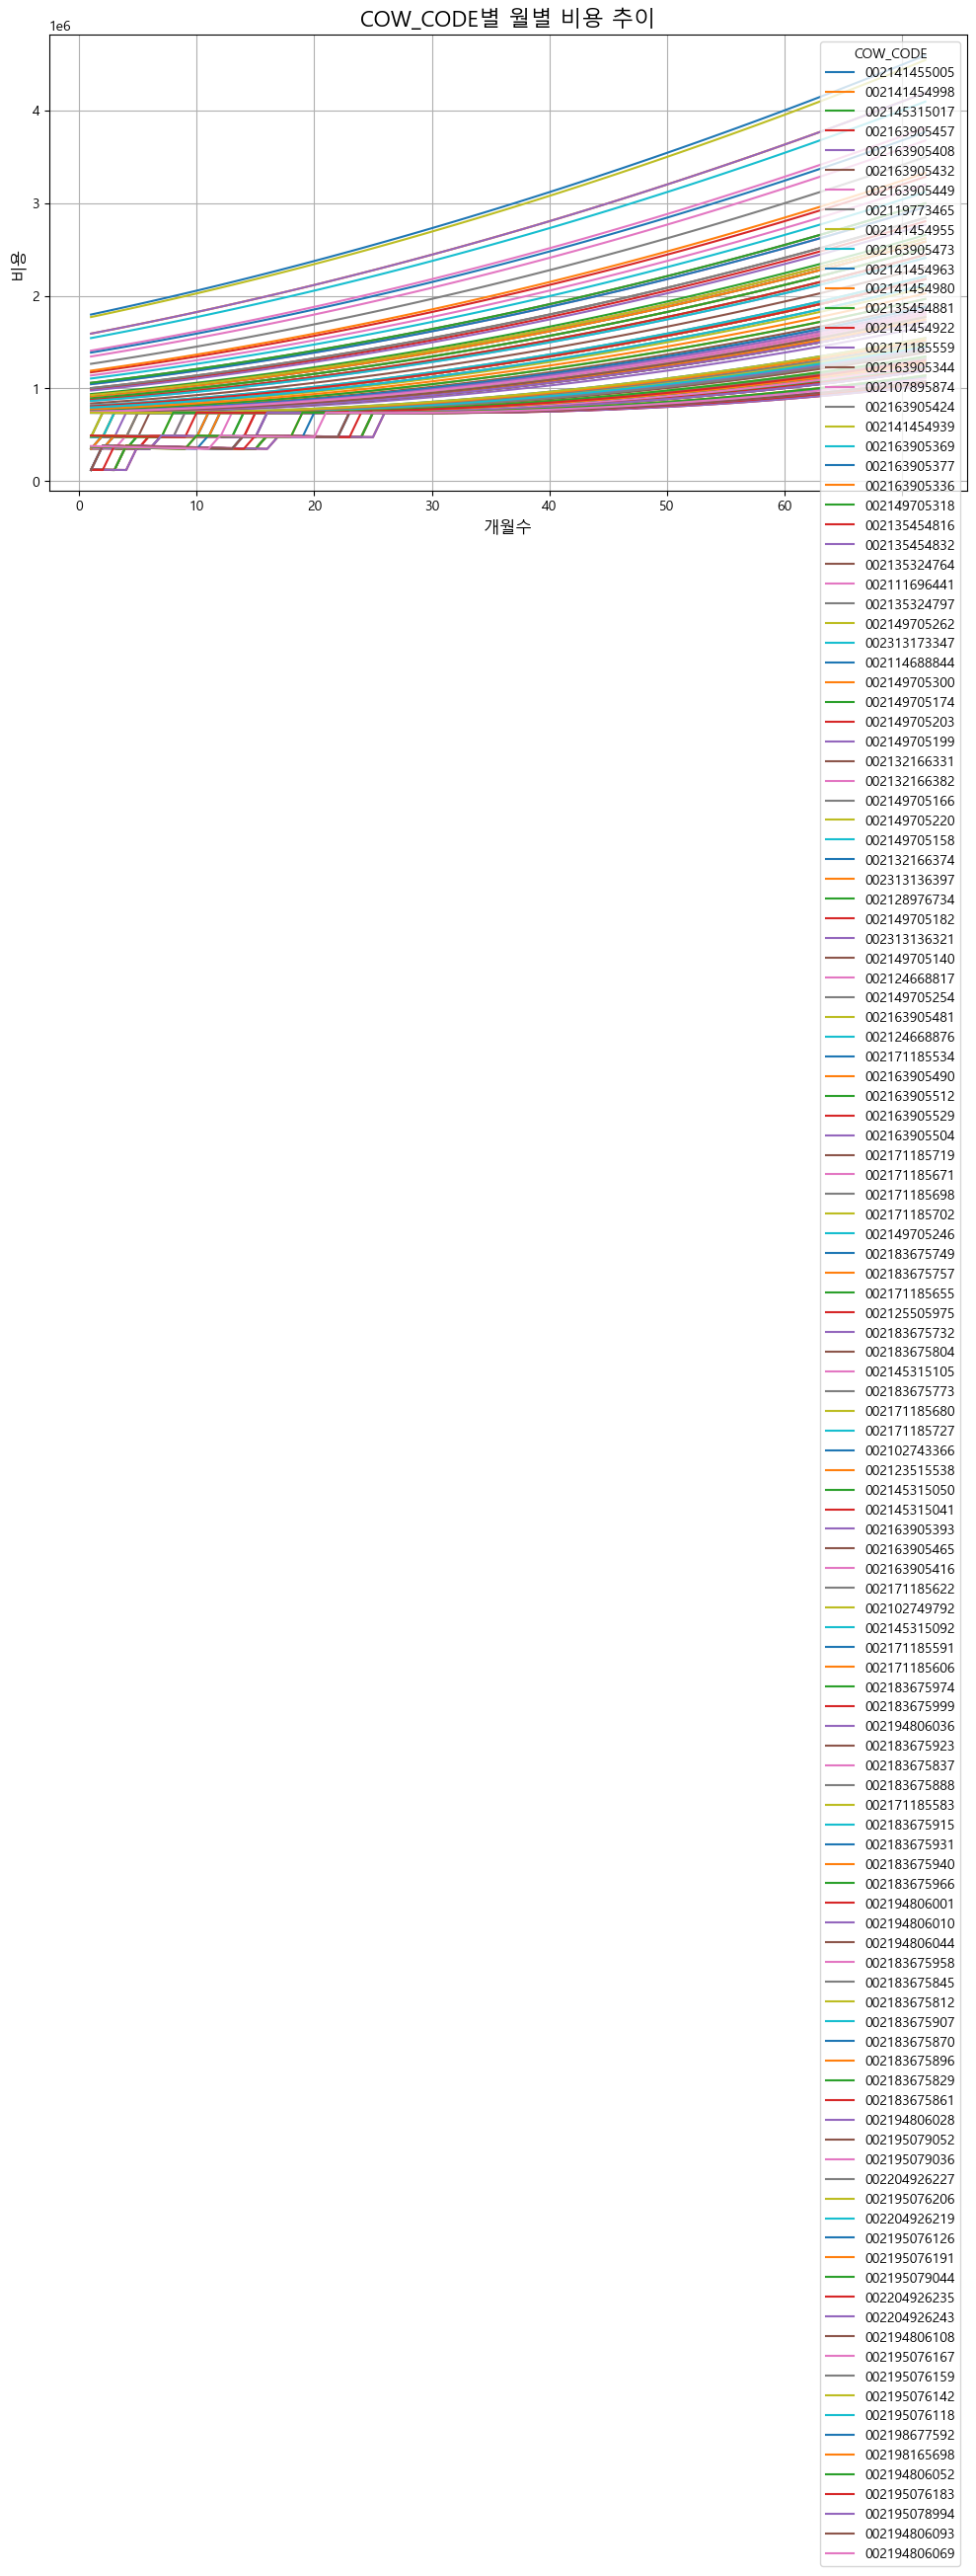

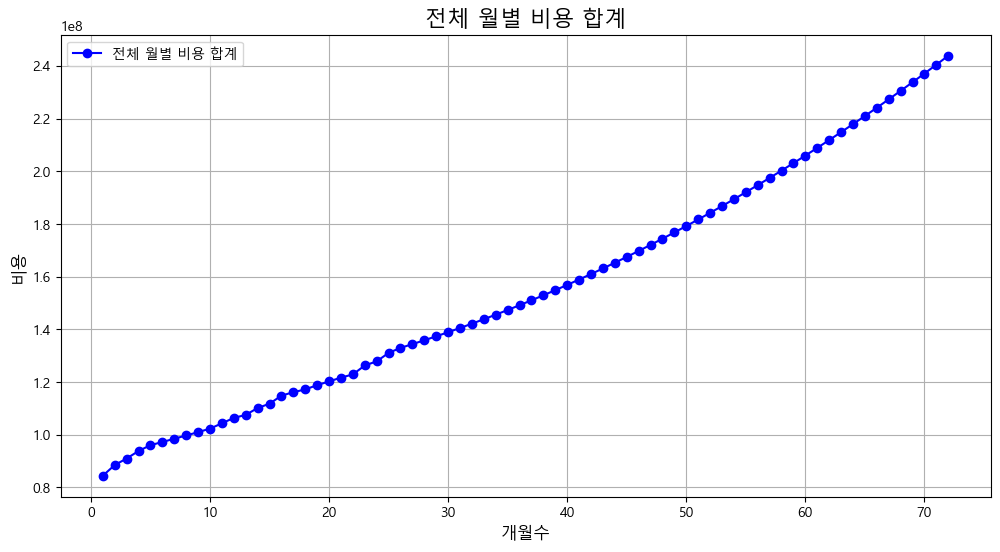

In [32]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False
font_path = "C:/Windows/Fonts/malgun.ttf"  # 윈도우 시스템 예제
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# COW_CODE별 선 그래프
plt.figure(figsize=(12, 6))
for index, row in df_combined_expanded.iterrows():
    months = range(1, 73)  # 1개월부터 72개월
    costs = row.iloc[6:].values  # 1개월후부터 72개월후 데이터 선택
    plt.plot(months, costs, label=row['COW_CODE'])

# 그래프 설정
plt.title("COW_CODE별 월별 비용 추이", fontsize=16)
plt.xlabel("개월수", fontsize=12)
plt.ylabel("비용", fontsize=12)
plt.legend(title="COW_CODE", fontsize=10)
plt.grid(True)

# COW_CODE별 그래프 출력
plt.show()

# 전체 월별 비용 합계 그래프
total_costs = df_combined_expanded.iloc[:, 6:].sum(axis=0).values
plt.figure(figsize=(12, 6))
plt.plot(range(1, 73), total_costs, marker='o', color='blue', label='전체 월별 비용 합계')

# 그래프 설정
plt.title("전체 월별 비용 합계", fontsize=16)
plt.xlabel("개월수", fontsize=12)
plt.ylabel("비용", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# 전체 월별 비용 그래프 출력
plt.show()


In [ ]:
connection.close()
print("데이터베이스 연결이 해제되었습니다.")